# **Description Cell 1: Notebook Objective**

**Description:** The purpose of this notebook is to conduct a comprehensive exploratory
data analysis (EDA) on the cleaned and feature-enriched dataset
(`analysis_ready_data.csv`). We will generate a series of visualizations to
understand variable distributions, temporal trends, geographic patterns, and the
correlations between key variables like PM₂.₅, Socio-Demographic Index (SDI),
and Disability-Adjusted Life Years (DALYs). The outputs of this notebook will be
saved figures and a summary table of country-level metrics.

In [ ]:
# Import necessary libraries
import pandas as pd

# import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from pathlib import Path

# Define file paths
# Assumes the notebook is in the '4_data_analysis' folder
input_file = Path("../4_data_analysis/output_data/analysis_ready_data.csv")
figure_dir = Path("../4_data_analysis/figures/eda_plots/")
output_metrics_file = Path("../4_data_analysis/output_data/country_level_averages.csv")

# Ensure the output directories exist
figure_dir.mkdir(parents=True, exist_ok=True)
output_metrics_file.parent.mkdir(parents=True, exist_ok=True)

# Set plotting style for consistency
sns.set_theme(style="whitegrid", palette="viridis")
plt.rcParams["figure.figsize"] = (14, 8)

### **Code Cell 2: Load Processed Data**

**Description:** This cell loads the `analysis_ready_data.csv` file created by
the previous notebook (`01_data_quality_prep.ipynb`). We then preview the first
few rows to confirm that the data, including the engineered features, has been
loaded correctly.

In [10]:
# Load the analysis-ready dataset
try:
    df = pd.read_csv(input_file)
    print(f"Successfully loaded data from: {input_file}")
    print(f"Dataset shape: {df.shape}")
    display(df.head())
except FileNotFoundError:
    print(f"Error: The file {input_file} was not found.")
    print("Please ensure you have run the '01_data_quality_prep.ipynb' notebook first.")

# Convert 'SDI_category' to ordered categorical for correct plotting
if "SDI_category" in df.columns:
    df["SDI_category"] = pd.Categorical(
        df["SDI_category"],
        categories=["Low", "Medium", "High", "Very High"],
        ordered=True,
    )

Successfully loaded data from: ..\4_data_analysis\output_data\analysis_ready_data.csv
Dataset shape: (1950, 14)


,Country,Year,SDI,PM2.5,All-cause DALYs,Cardiovascular DALYs,Stroke DALYs,Respiratory DALYs,PM25_lag1,PM25_lag2,PM25_3yr_avg,PM25_5yr_avg,PM25_SDI_interaction,SDI_category
0,Afghanistan,2010,0.247760,68.97,964.624572,552.532736,233.909069,93.718564,NaN,NaN,68.970000,68.970000,17.088004,Low
1,Afghanistan,2011,0.257042,66.94,993.638916,574.733306,240.461645,96.669076,68.97,NaN,67.955000,67.955000,17.206370,Low
2,Afghanistan,2012,0.266484,68.26,1094.905421,638.051013,265.716358,107.069984,66.94,68.97,68.056667,68.056667,18.190226,Low
3,Afghanistan,2013,0.275637,72.18,1226.174063,716.535411,294.512524,118.866012,68.26,66.94,69.126667,69.087500,19.895447,Low
4,Afghanistan,2014,0.284030,68.06,1330.059507,781.602468,317.720058,128.256003,72.18,68.26,69.500000,68.882000,19.331106,Low


### **Code Cell 3: Descriptive Statistics and Distributions**

**Description:** This step computes and visualizes summary statistics for the key
variables. We generate histograms and boxplots to understand the shape of each
variable's distribution and identify potential outliers.

--- Summary Statistics for Key Variables ---


,PM2.5,SDI,All-cause DALYs,Cardiovascular DALYs,Stroke DALYs,Respiratory DALYs
count,1950.000000,1950.000000,1950.000000,1950.000000,1950.000000,1950.000000
mean,22.667046,0.611078,1280.523022,684.612117,266.985368,101.164185
std,14.406437,0.181369,906.771629,617.279167,212.394733,88.896765
min,4.920000,0.064322,68.444384,31.440826,6.752929,4.474057
25%,11.390000,0.472284,580.027784,261.919746,108.565738,46.159459
50%,18.810000,0.631099,1102.711462,508.036392,229.502752,75.390563
75%,29.865000,0.758528,1747.406195,887.002563,370.287977,126.758037
max,72.180000,0.930682,6763.651135,4903.886640,1550.857943,615.455031


--- Variable Distributions (Histograms) ---


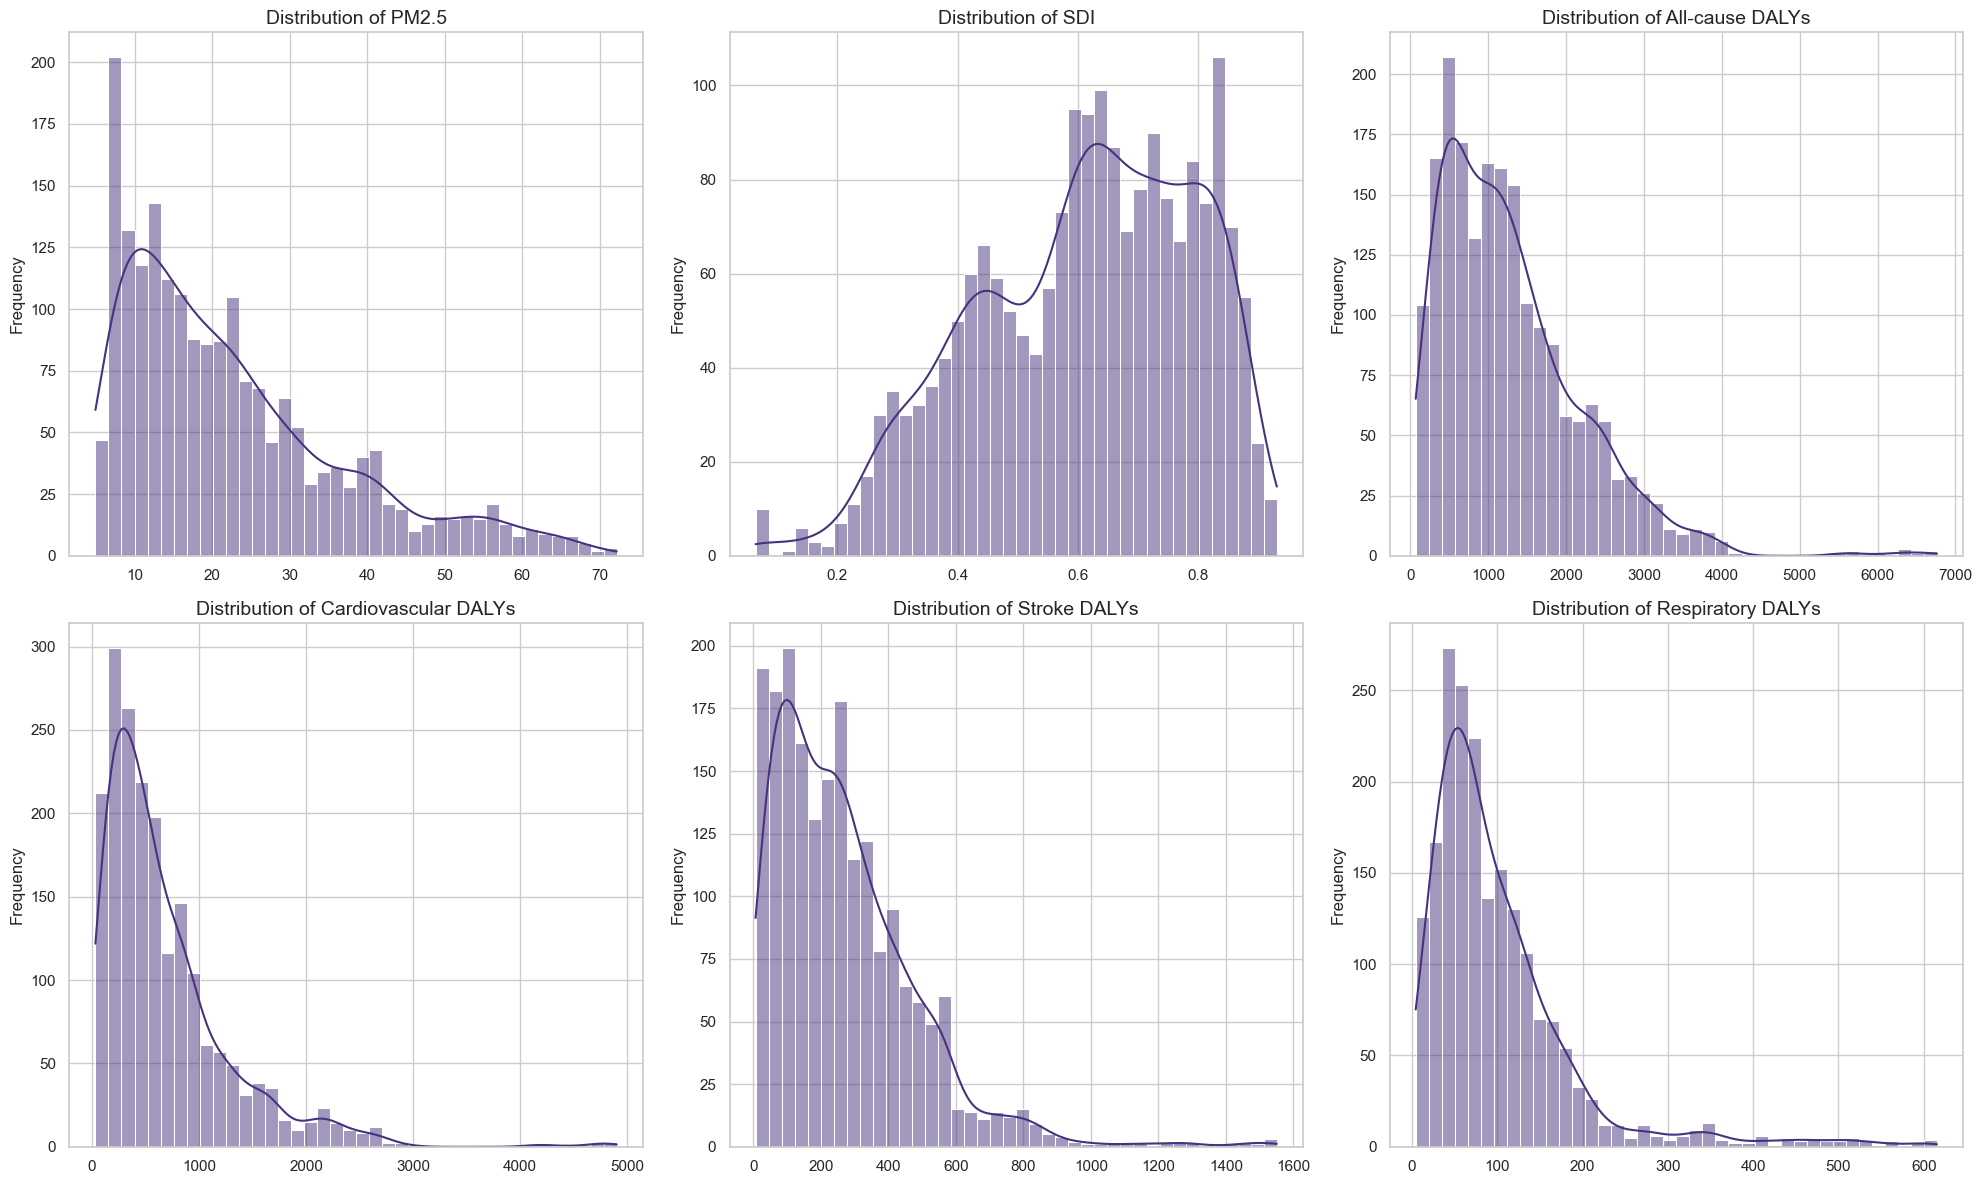

In [11]:
# 3.1 Define key variables and generate summary statistics
key_vars = [
    "PM2.5",
    "SDI",
    "All-cause DALYs",
    "Cardiovascular DALYs",
    "Stroke DALYs",
    "Respiratory DALYs",
]
summary_stats = df[key_vars].describe()
print("--- Summary Statistics for Key Variables ---")
display(summary_stats)

# 3.2 Visualize distributions with histograms
print("--- Variable Distributions (Histograms) ---")
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()
for i, var in enumerate(key_vars):
    sns.histplot(df[var].dropna(), bins=40, kde=True, ax=axes[i])
    axes[i].set_title(f"Distribution of {var}", fontsize=14)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("Frequency")
plt.tight_layout()
plt.savefig(figure_dir / "fig_01_distributions.png")
plt.show()

### **Code Cell 4: Temporal Trends Analysis by SDI Category**

**Description:** This cell visualizes how PM₂.₅ and the various DALY metrics have
evolved from 2010 to 2019. The data is stratified by SDI category, creating
faceted plots that show trends for each development group and disease type
separately.

--- Generating Temporal Trend Plots for DALYs by SDI Category ---


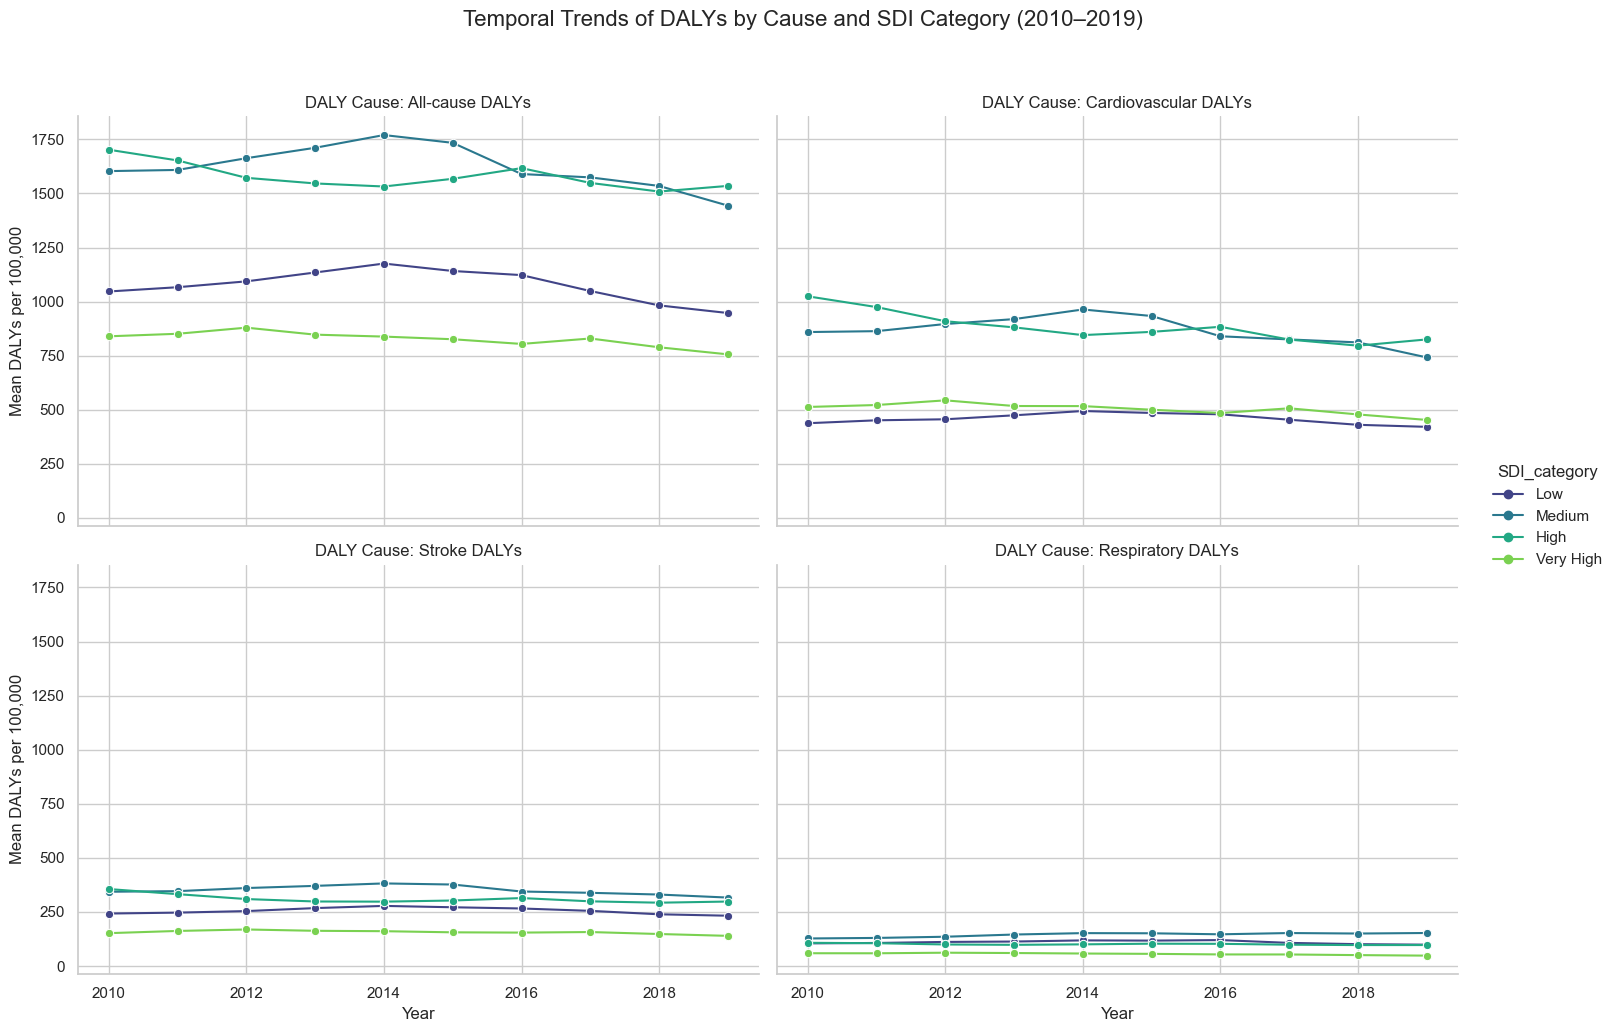

In [12]:
# 4.1 'Melt' the DataFrame for faceted plotting
daly_vars = [
    "All-cause DALYs",
    "Cardiovascular DALYs",
    "Stroke DALYs",
    "Respiratory DALYs",
]
id_vars = ["Year", "SDI_category"]
df_melted = (
    df[id_vars + daly_vars]
    .dropna()
    .melt(id_vars=id_vars, var_name="DALY Cause", value_name="DALY Value")
)

# 4.2 Create the faceted line plot for DALY trends
print("--- Generating Temporal Trend Plots for DALYs by SDI Category ---")
g = sns.relplot(
    data=df_melted,
    x="Year",
    y="DALY Value",
    hue="SDI_category",
    col="DALY Cause",
    kind="line",
    col_wrap=2,
    palette="viridis",
    marker="o",
    errorbar=None,
    height=5,
    aspect=1.5,
    legend="full",
)
g.fig.suptitle(
    "Temporal Trends of DALYs by Cause and SDI Category (2010–2019)",
    y=1.03,
    fontsize=16,
)
g.set_axis_labels("Year", "Mean DALYs per 100,000")
g.set_titles("DALY Cause: {col_name}")
g.tight_layout()
plt.savefig(figure_dir / "fig_02_daly_trends_by_sdi.png")
plt.show()

### **Code Cell 5: Geographic and Cross-Country Comparisons**

**Description:** This cell aggregates the data to the country level to compare
outcomes. It generates bar charts showing the top and bottom 10 countries by
average PM₂.₅, and a scatter plot that visualizes the relationship between
PM₂.₅ and All-cause DALYs, color-coded by SDI category.

--- Top 10 Countries by Average PM2.5 ---


C:\Users\SiSaR\AppData\Local\Temp\ipykernel_50668\144757012.py:22: UserWarning:

Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.

C:\Users\SiSaR\AppData\Local\Temp\ipykernel_50668\144757012.py:22: UserWarning:

Glyph 8325 (\N{SUBSCRIPT FIVE}) missing from font(s) Arial.

C:\Users\SiSaR\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.

C:\Users\SiSaR\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 8325 (\N{SUBSCRIPT FIVE}) missing from font(s) Arial.



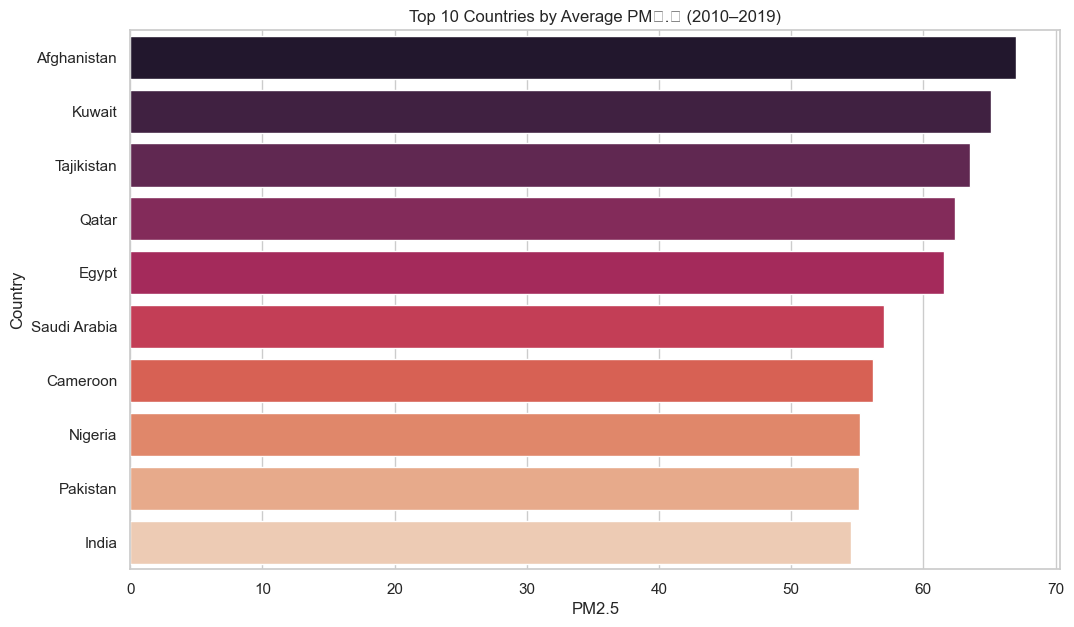

C:\Users\SiSaR\AppData\Local\Temp\ipykernel_50668\144757012.py:38: UserWarning:

Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.



--- Bottom 10 Countries by Average PM2.5 ---


C:\Users\SiSaR\AppData\Local\Temp\ipykernel_50668\144757012.py:38: UserWarning:

Glyph 8325 (\N{SUBSCRIPT FIVE}) missing from font(s) Arial.

C:\Users\SiSaR\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.

C:\Users\SiSaR\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 8325 (\N{SUBSCRIPT FIVE}) missing from font(s) Arial.



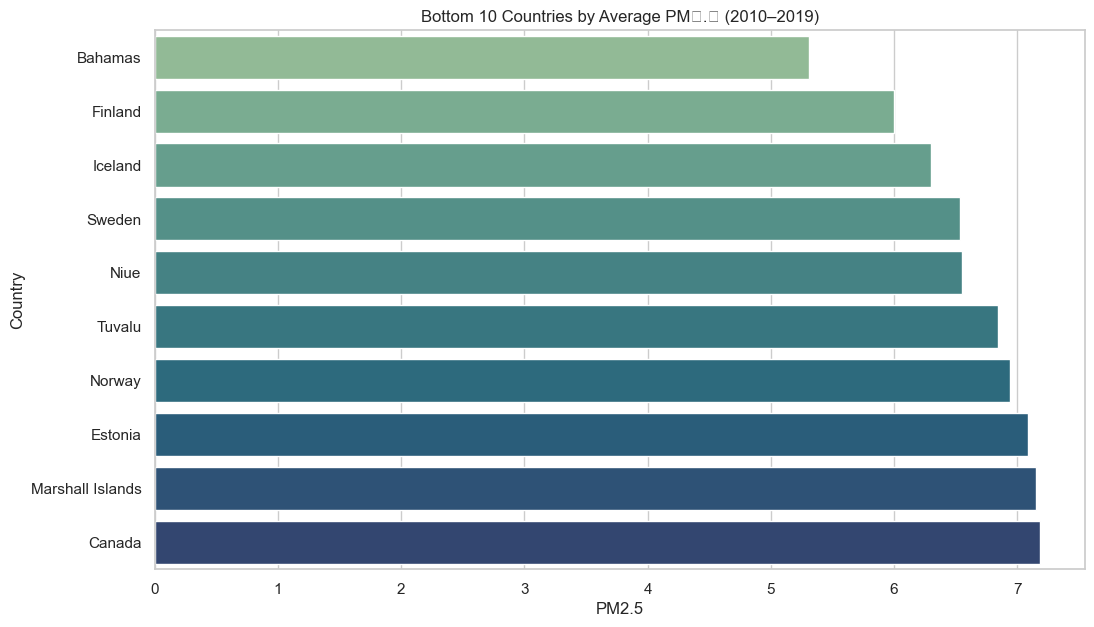

C:\Users\SiSaR\AppData\Local\Temp\ipykernel_50668\144757012.py:60: UserWarning:

Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.



--- PM2.5 vs. DALYs, Stratified by SDI ---


C:\Users\SiSaR\AppData\Local\Temp\ipykernel_50668\144757012.py:60: UserWarning:

Glyph 8325 (\N{SUBSCRIPT FIVE}) missing from font(s) Arial.

C:\Users\SiSaR\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.

C:\Users\SiSaR\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 8325 (\N{SUBSCRIPT FIVE}) missing from font(s) Arial.



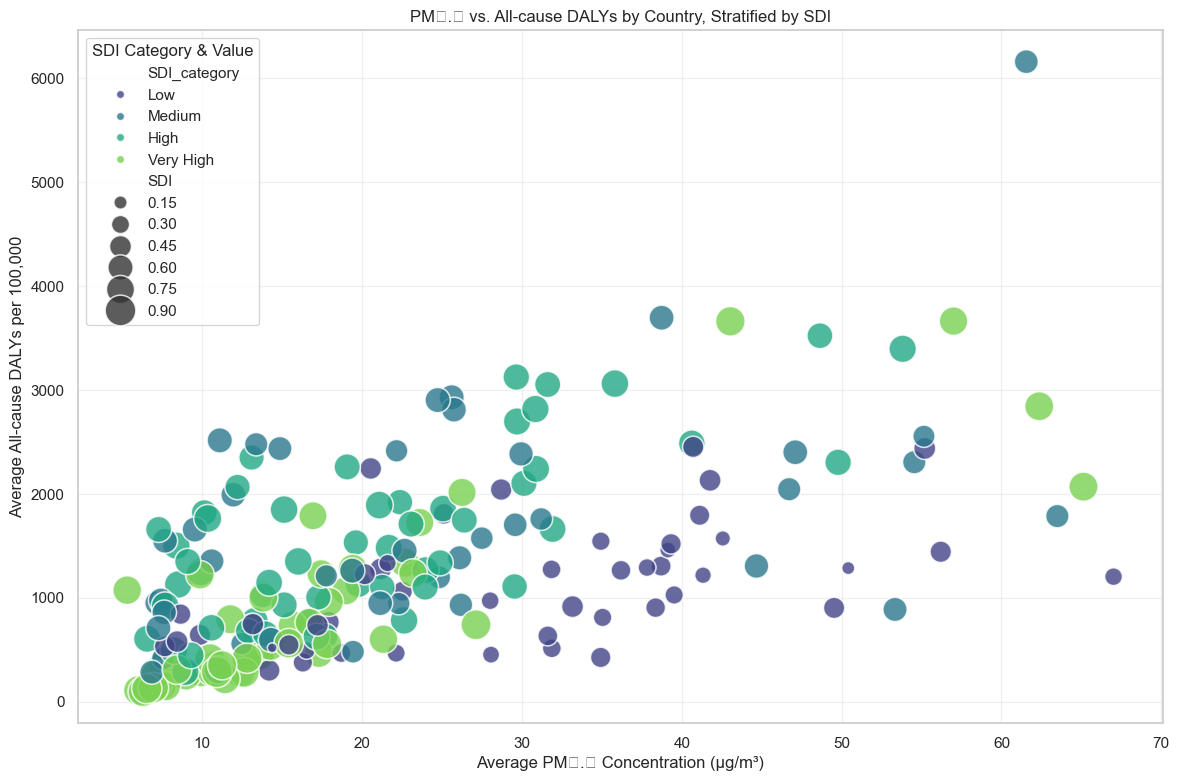

In [13]:
# 5.1 Calculate average metrics per country
country_avg = df.groupby("Country", as_index=False).agg(
    {
        "PM2.5": "mean",
        "All-cause DALYs": "mean",
        "SDI": "mean",
        "SDI_category": lambda x: x.mode().iloc[0],
    }
)

# 5.2 Top 10 Countries by Average PM2.5
print("--- Top 10 Countries by Average PM2.5 ---")
top_10_pm25 = country_avg.sort_values("PM2.5", ascending=False).head(10)
plt.figure(figsize=(12, 7))
sns.barplot(
    data=top_10_pm25,
    x="PM2.5",
    y="Country",
    hue="Country",
    palette="rocket",
    legend=False,
)
plt.title("Top 10 Countries by Average PM₂.₅ (2010–2019)")
plt.savefig(figure_dir / "fig_03_top10_pm25.png")
plt.show()

# 5.3 Bottom 10 Countries by Average PM2.5
print("--- Bottom 10 Countries by Average PM2.5 ---")
bottom_10_pm25 = country_avg.sort_values("PM2.5", ascending=True).head(10)
plt.figure(figsize=(12, 7))
sns.barplot(
    data=bottom_10_pm25,
    x="PM2.5",
    y="Country",
    hue="Country",
    palette="crest",
    legend=False,
)
plt.title("Bottom 10 Countries by Average PM₂.₅ (2010–2019)")
plt.savefig(figure_dir / "fig_04_bottom10_pm25.png")
plt.show()

# 5.4 Scatter plot of PM2.5 vs. DALYs, colored by SDI category
print("--- PM2.5 vs. DALYs, Stratified by SDI ---")
plt.figure(figsize=(14, 9))
sns.scatterplot(
    data=country_avg,
    x="PM2.5",
    y="All-cause DALYs",
    hue="SDI_category",
    size="SDI",
    sizes=(50, 500),
    palette="viridis",
    alpha=0.8,
    hue_order=["Low", "Medium", "High", "Very High"],
)
plt.title("PM₂.₅ vs. All-cause DALYs by Country, Stratified by SDI")
plt.xlabel("Average PM₂.₅ Concentration (µg/m³)")
plt.ylabel("Average All-cause DALYs per 100,000")
plt.legend(title="SDI Category & Value")
plt.grid(True, alpha=0.3)
plt.savefig(figure_dir / "fig_05_pm25_vs_dalys_by_sdi.png")
plt.show()

### **Code Cell 6: Geographic Map (Choropleth)**

**Description:** This cell uses `plotly.express` to create an interactive
choropleth world map showing average PM₂.₅ concentrations globally.

In [14]:
# 6.1 Create the Choropleth map
print("--- Geographic Distribution of Average PM2.5 ---")
fig = px.choropleth(
    country_avg,
    locations="Country",
    locationmode="country names",
    color="PM2.5",
    hover_name="Country",
    color_continuous_scale=px.colors.sequential.Plasma,
    title="Geographic Distribution of Average PM₂.₅ Concentrations (2010–2019)",
)
# Save as HTML to preserve interactivity
fig.write_html(figure_dir / "fig_06_choropleth_map.html")
fig.show()

--- Geographic Distribution of Average PM2.5 ---


### **Code Cell 7: Correlation Analysis**

**Description:** This cell computes and visualizes the Pearson correlation matrix
for the key numerical variables using a heatmap.

--- Correlation Matrix of Key Variables ---


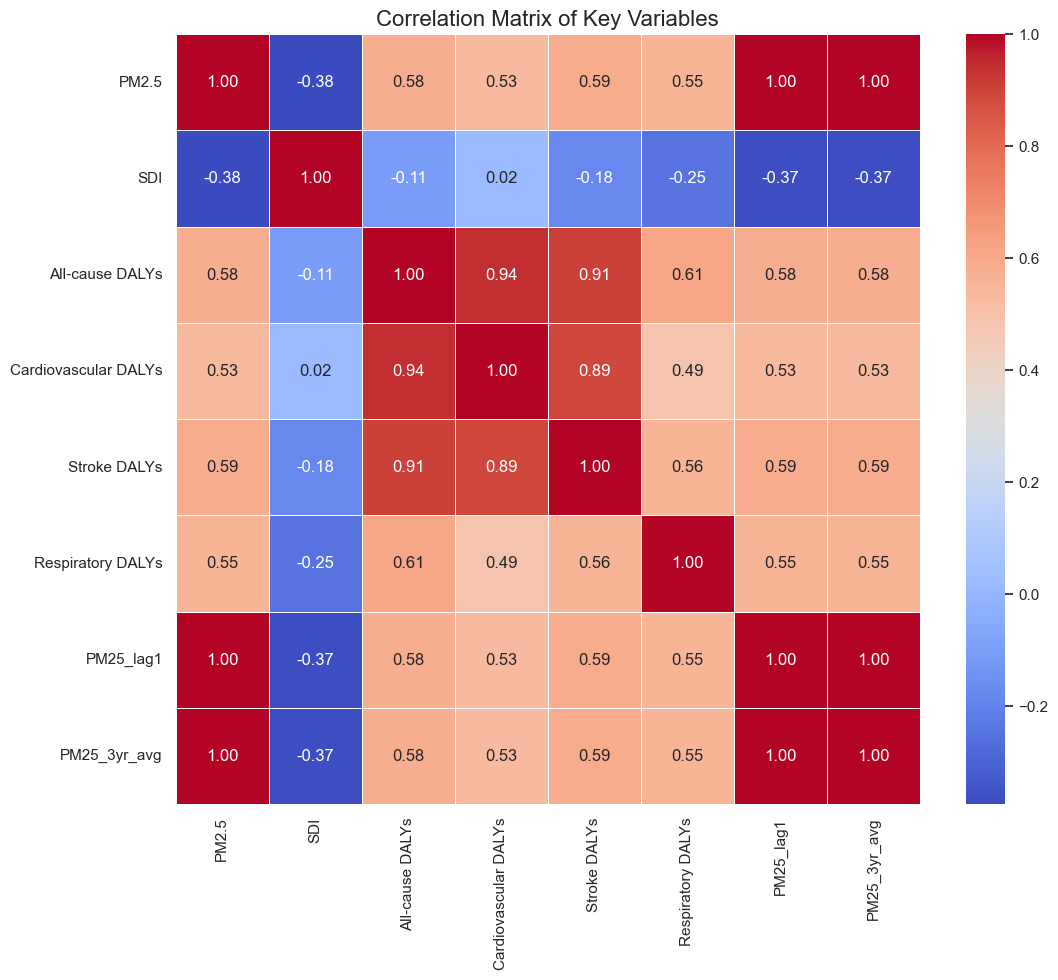

In [15]:
# 7.1 Select key numeric variables for correlation
correlation_vars = [
    "PM2.5",
    "SDI",
    "All-cause DALYs",
    "Cardiovascular DALYs",
    "Stroke DALYs",
    "Respiratory DALYs",
    "PM25_lag1",
    "PM25_3yr_avg",
]
df_corr = df[correlation_vars].dropna()

# 7.2 Compute and visualize the correlation matrix
print("--- Correlation Matrix of Key Variables ---")
corr_matrix = df_corr.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Key Variables", fontsize=16)
plt.savefig(figure_dir / "fig_07_correlation_matrix.png")
plt.show()

### **Code Cell 8: Export Summary Metrics**

**Description:** This final cell saves the `country_avg` DataFrame, which contains
the mean values for key metrics for each country, to a new CSV file for later use.

In [16]:
# Export the country-level averages to a CSV file
try:
    country_avg.to_csv(output_metrics_file, index=False)
    print(f"Successfully exported country-level averages to: {output_metrics_file}")
except Exception as e:
    print(f"An error occurred while exporting the file: {e}")

Successfully exported country-level averages to: ..\4_data_analysis\output_data\country_level_averages.csv
